# CyberSecure — Problem Statement 2 (Enhanced Visual Notebook)

This notebook contains rich visualizations, interactive flow input -> classification -> security action demo, and model training/evaluation cells. Run cells sequentially. Use the Dataset selection cell near the top to choose a CSV (the workspace includes `/mnt/data/test_samples.csv`).

In [ ]:
# CyberSecure — Problem Statement 2 (Enhanced Visual Notebook)

This notebook contains rich visualizations, interactive flow input → classification → security action demo, and model training/evaluation cells.
Run cells sequentially. Use the Dataset selection cell near the top to choose a CSV (the workspace includes `/mnt/data/test_samples.csv`).


In [1]:
# Cell 2: imports & config
import os
import glob
import numpy as np
import pandas as pd
import joblib
import hashlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# widgets
try:
    import ipywidgets as widgets
    from IPython.display import display, HTML, clear_output
    WIDGETS_AVAILABLE = True
except Exception:
    WIDGETS_AVAILABLE = False

MODEL_DIR = 'models'
os.makedirs(MODEL_DIR, exist_ok=True)
plt.rcParams['figure.figsize'] = (8,5)


In [2]:
# NEW Cell 3: dataset dropdown (ONLY look inside ./data folder)

import os, glob
import pandas as pd

DATA_FOLDER = os.path.join(os.getcwd(), "data")   # <-- Force search in ./data/

if not os.path.exists(DATA_FOLDER):
    raise FileNotFoundError(f"The 'data' folder was not found at: {DATA_FOLDER}")

# Find CSV files ONLY inside /data/
found_csvs = glob.glob(os.path.join(DATA_FOLDER, "*.csv"))

# Remove duplicates & make absolute paths
options = [os.path.abspath(f) for f in found_csvs]

if not options:
    print("No CSV files found inside the /data/ folder.")
else:
    print("Found CSVs inside /data/:")
    for o in options:
        print(" -", o)

# Dataset selector widget
if WIDGETS_AVAILABLE and options:
    dataset_dropdown = widgets.Dropdown(options=options, description='Dataset:')
    load_button = widgets.Button(description='Load dataset', button_style='primary')
    out = widgets.Output()

    def _load_dataset(b):
        with out:
            clear_output()
            selected = dataset_dropdown.value
            print(f"Loading dataset: {selected}")
            global DATA_PATH
            DATA_PATH = selected
            preview = pd.read_csv(DATA_PATH, nrows=5)
            print("\nPreview (first 5 rows):")
            display(preview)

    load_button.on_click(_load_dataset)
    display(widgets.HBox([dataset_dropdown, load_button]), out)

else:
    if options:
        DATA_PATH = options[0]
        print("Widgets not available — automatically selecting:")
        print(" DATA_PATH =", DATA_PATH)
        preview = pd.read_csv(DATA_PATH, nrows=5)
        print("\nPreview:")
        display(preview)
    else:
        DATA_PATH = None
        print("No dataset selected.")

print("\nAfter choosing DATA_PATH, run the remaining cells.")



Found CSVs inside /data/:
 - C:\Users\Sam\Desktop\LBC\CyberSecure-Redact\data\cleaned_data.csv
 - C:\Users\Sam\Desktop\LBC\CyberSecure-Redact\data\test_samples.csv


Output()


After choosing DATA_PATH, run the remaining cells.


In [8]:
# Cell 4: load dataset and quick checks
if 'DATA_PATH' not in globals() or DATA_PATH is None:
    raise FileNotFoundError("DATA_PATH is not set. Run the dataset selection cell and choose a CSV first.")

raw = pd.read_csv(DATA_PATH)
print(f'Loaded dataset with {raw.shape[0]} rows and {raw.shape[1]} columns')
display(raw.head())


Loaded dataset with 500 rows and 53 columns


,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,80.0,1861005.0,3.0,26.0,20.0,0.0,8.666667,10.263203,7215.0,0.0,...,229.0,2.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,DDoS
1,80.0,15222541.0,5.0,460.0,442.0,0.0,92.000000,195.673200,183.0,0.0,...,123.0,4.0,20.0,471261.0,471261.0,471261.0,9962336.0,9962336.0,9962336.0,Normal Traffic
2,53236.0,4.0,2.0,12.0,6.0,6.0,6.000000,0.000000,0.0,0.0,...,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic
3,57726.0,3.0,2.0,37.0,31.0,6.0,18.500000,17.677670,0.0,0.0,...,-1.0,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic
4,1192.0,96.0,2.0,4.0,2.0,2.0,2.000000,0.000000,6.0,6.0,...,0.0,1.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,Normal Traffic


In [9]:
# Cell 5: preprocessing
df = raw.copy()

# Expecting label column 'Attack Type' as used in the notebook; rename if your CSV uses a different column name.
if 'Attack Type' not in df.columns:
    raise KeyError("Expected column 'Attack Type' in the cleaned CSV. If it's named differently, rename it or update this cell.")

le = LabelEncoder()
df['target'] = le.fit_transform(df['Attack Type'])

feature_cols = [c for c in df.columns if c not in ['Attack Type', 'target']]

# Convert object columns to float where possible; otherwise drop them (these likely are non-numeric metadata)
for c in feature_cols[:]:
    if df[c].dtype == 'object':
        try:
            df[c] = df[c].astype(float)
        except Exception:
            df.drop(columns=[c], inplace=True)

feature_cols = [c for c in df.columns if c not in ['Attack Type', 'target']]
print('Final feature columns count:', len(feature_cols))

X = df[feature_cols].fillna(0).astype(np.float32)
y = df['target']

# scaled copy for embeddings/plots
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)


Final feature columns count: 52


In [31]:
# CELL 6 — COMPLETE & CORRECTED

def eda_dashboard(model=None, show=True):
    """
    Fully corrected EDA Dashboard with:
    - Automatic X_scaled rebuilding to ensure row count matches X and y
    - Safe PCA scatter (no RGBA errors, no length mismatch)
    - Clean plots for distribution, feature importance, correlation, etc.
    """

    import matplotlib.gridspec as gridspec
    from sklearn.decomposition import PCA
    from sklearn.preprocessing import StandardScaler

    # ------------------------------------------------------------
    # 1. FIX DATA MISMATCH: REBUILD X_scaled TO MATCH X EXACTLY
    # ------------------------------------------------------------
    global X_scaled

    if 'X_scaled' in globals():
        if X_scaled.shape[0] != X.shape[0]:
            print("Fixing mismatch: rebuilding X_scaled to match X.")
            scaler = StandardScaler()
            X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    else:
        scaler = StandardScaler()
        X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    # ------------------------------------------------------------
    # 2. FIGURE LAYOUT
    # ------------------------------------------------------------
    fig = plt.figure(constrained_layout=True, figsize=(16, 10))
    spec = gridspec.GridSpec(ncols=3, nrows=2, figure=fig)

    # ------------------------------------------------------------
    # Top-left: Class distribution
    # ------------------------------------------------------------
    ax0 = fig.add_subplot(spec[0, 0])
    counts = df['Attack Type'].value_counts()
    counts.plot(kind='barh', ax=ax0)
    ax0.set_title('Class distribution (counts)')
    ax0.set_xlabel('')
    ax0.set_ylabel('Attack Type')

    # ------------------------------------------------------------
    # Top-center: Feature importances
    # ------------------------------------------------------------
    ax1 = fig.add_subplot(spec[0, 1])
    if model is not None and hasattr(model, "feature_importances_"):
        importances = model.feature_importances_
        idx = np.argsort(importances)[-10:][::-1]
        top_feats = X.columns[idx]
        sns.barplot(x=importances[idx], y=top_feats, ax=ax1)
        ax1.set_title('Top 10 Feature Importances')
    else:
        ax1.text(0.5, 0.5, "No model or feature_importances_", ha='center')
        ax1.set_title('Top 10 Feature Importances')

    # ------------------------------------------------------------
    # Top-right: Correlation heatmap
    # ------------------------------------------------------------
    ax2 = fig.add_subplot(spec[0, 2])
    corr = X.iloc[:, :12].corr()
    sns.heatmap(corr, ax=ax2, annot=False, cbar=True)
    ax2.set_title("Correlation (Top 12 Features)")
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    # ------------------------------------------------------------
    # Bottom-left: Sample histograms
    # ------------------------------------------------------------
    ax3 = fig.add_subplot(spec[1, 0])
    sample_feats = X.columns[:6]
    for f in sample_feats:
        try:
            sns.kdeplot(X[f].dropna(), ax=ax3, label=f)
        except:
            ax3.hist(X[f].dropna(), bins=30, alpha=0.3, label=f)
    ax3.legend(fontsize='small')
    ax3.set_title('Sample Feature Histograms')

    # ------------------------------------------------------------
    # Bottom-center: PCA scatter (FINAL FIXED VERSION)
    # ------------------------------------------------------------
    ax4 = fig.add_subplot(spec[1, 1])
    pca = PCA(n_components=2)

    proj = pca.fit_transform(X_scaled.values)
    n_pts = proj.shape[0]

    y_aligned = pd.Series(y).reset_index(drop=True)
    if len(y_aligned) != n_pts:
        print("Aligning y to match PCA size.")
        y_aligned = y_aligned.iloc[:n_pts].reset_index(drop=True)

    cat = pd.Categorical(y_aligned)
    label_codes = cat.codes.astype(int)

    scatter = ax4.scatter(proj[:, 0], proj[:, 1],
                          c=label_codes,
                          cmap='tab20',
                          alpha=0.6,
                          s=24,
                          edgecolors='none')

    ax4.set_title("PCA 2D Projection (Color = Label)")
    ax4.set_xlabel("PC1")
    ax4.set_ylabel("PC2")

    handles, labels = scatter.legend_elements()
    label_map = {str(i): name for i, name in enumerate(cat.categories)}
    legend_labels = [label_map.get(lbl, lbl) for lbl in labels]
    ax4.legend(handles, legend_labels,
               title="Attack Type",
               bbox_to_anchor=(1.05, 1),
               loc="upper left",
               fontsize="small")

    # ------------------------------------------------------------
    # Bottom-right: Boxplot
    # ------------------------------------------------------------
    ax5 = fig.add_subplot(spec[1, 2])
    f = X.columns[0]
    sns.boxplot(x=df['Attack Type'], y=X[f], ax=ax5)
    ax5.set_title(f'Boxplot of {f} by Attack Type')
    plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')

    # ------------------------------------------------------------
    # Show or return figure
    # ------------------------------------------------------------
    if show:
        plt.show()
    else:
        return fig


Fixing mismatch: rebuilding X_scaled to match X.


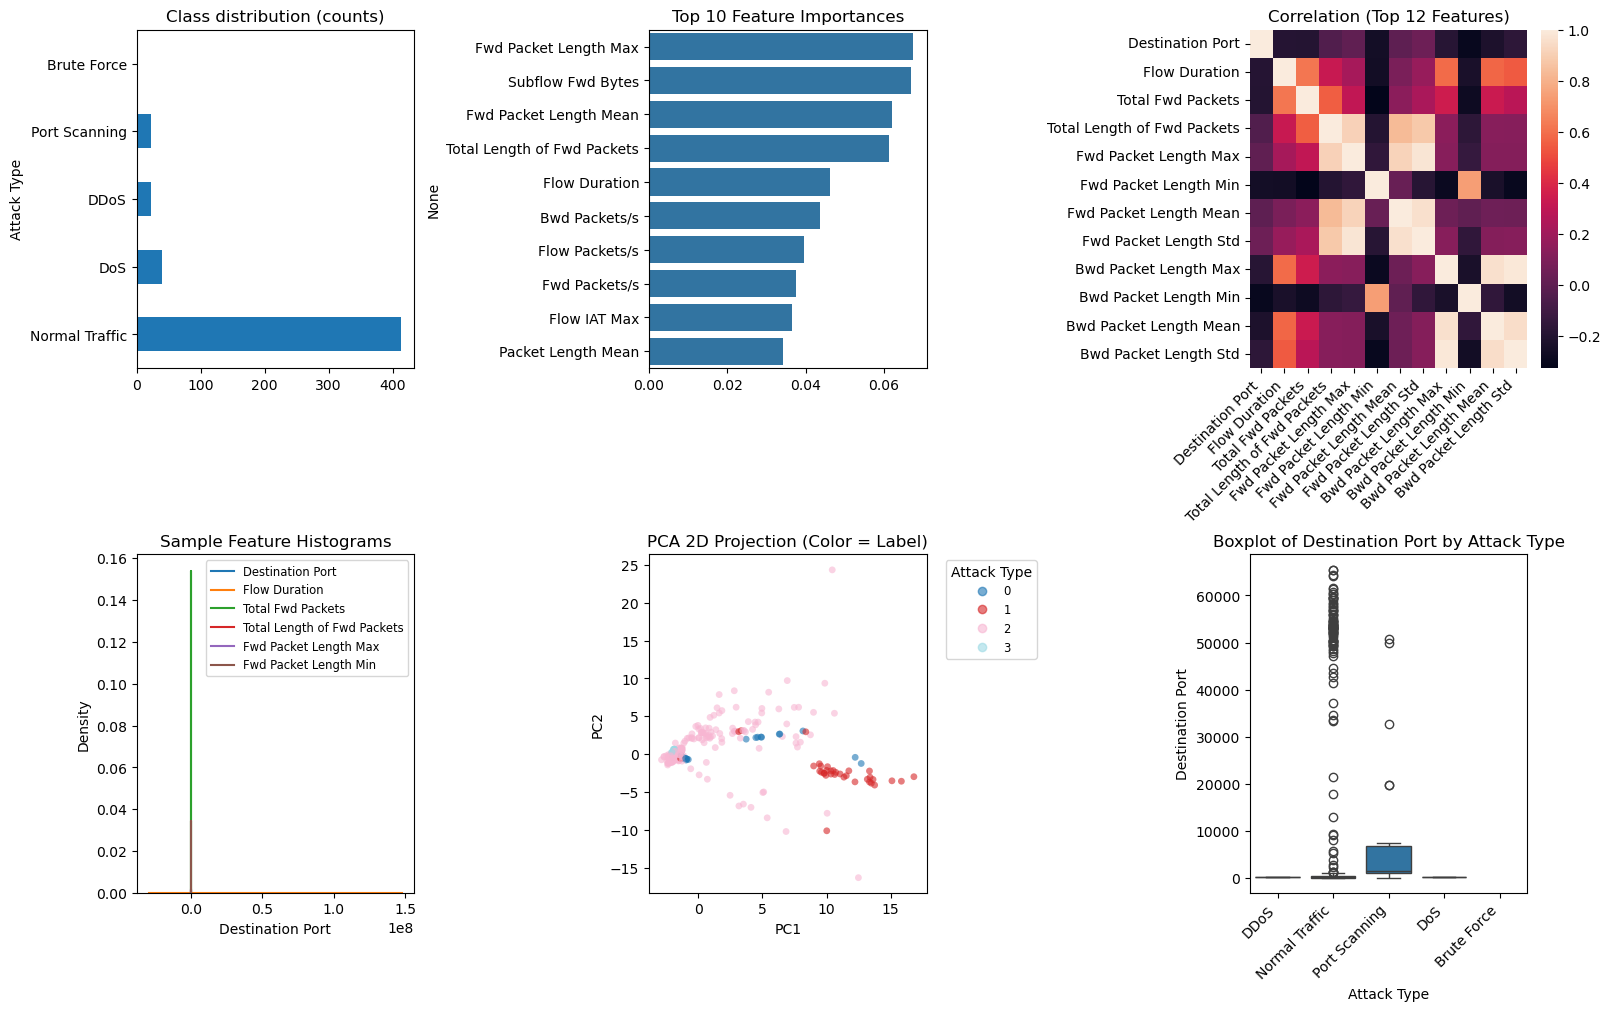

In [32]:
# CELL 7 — RUN EDA DASHBOARD

eda_dashboard(model=model if 'model' in globals() else None)


Train/test sizes: (374, 52) (125, 52)
Loaded existing model from models\rf_model_enhanced.pkl


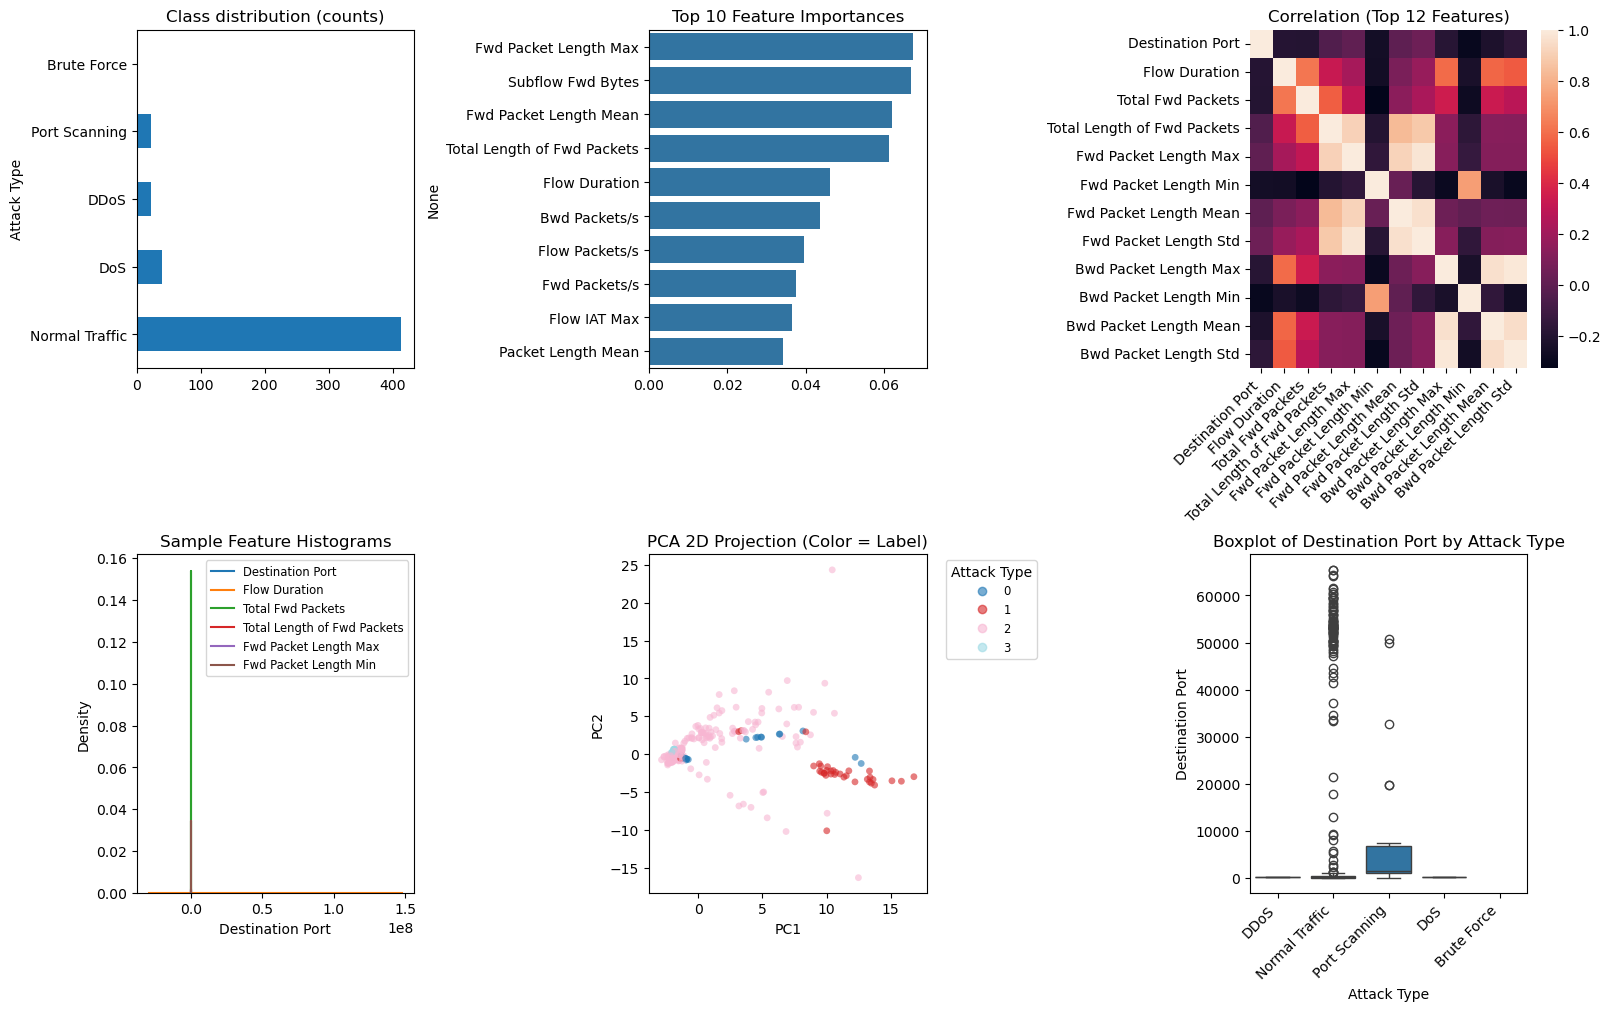

In [33]:
# Cell 8: train/test split and model training
# Remove classes that appear only once
value_counts = y.value_counts()
valid_classes = value_counts[value_counts > 1].index
X = X[y.isin(valid_classes)]
y = y[y.isin(valid_classes)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print('Train/test sizes:', X_train.shape, X_test.shape)

model_file = os.path.join(MODEL_DIR, 'rf_model_enhanced.pkl')
if os.path.exists(model_file):
    model = joblib.load(model_file)
    print('Loaded existing model from', model_file)
else:
    print('Training RandomForest (this may take a while)...')
    model = RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced')
    model.fit(X_train, y_train)
    joblib.dump(model, model_file)
    print('Saved model to', model_file)

# persist label encoder & columns for inference
joblib.dump(le, os.path.join(MODEL_DIR, 'label_encoder.pkl'))
joblib.dump(X.columns.tolist(), os.path.join(MODEL_DIR, 'columns.pkl'))

# show EDA with importances now that model exists
eda_dashboard(model=model)


Accuracy: 0.9840  |  Recall (weighted): 0.9840  |  Precision: 0.9843  |  F1: 0.9832

Classification report:

                precision    recall  f1-score   support

          DDoS       1.00      1.00      1.00         6
           DoS       1.00      0.80      0.89        10
Normal Traffic       0.98      1.00      0.99       103
 Port Scanning       1.00      1.00      1.00         6

      accuracy                           0.98       125
     macro avg       1.00      0.95      0.97       125
  weighted avg       0.98      0.98      0.98       125



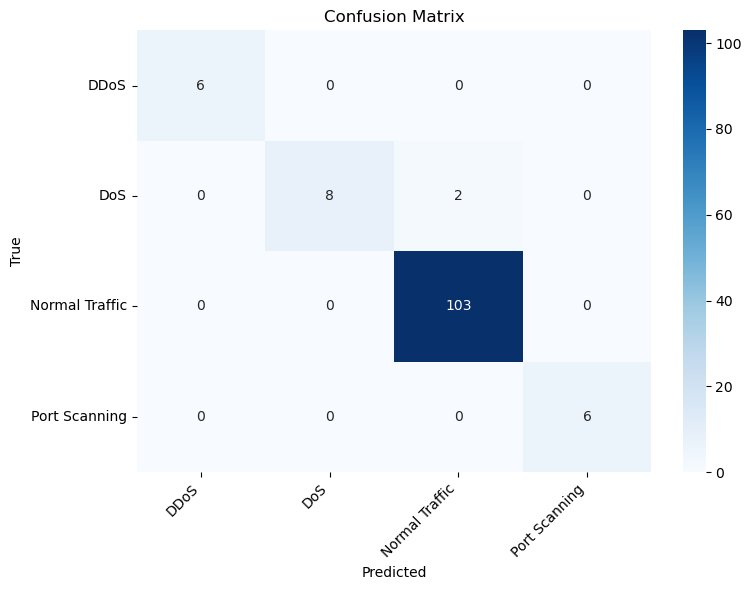

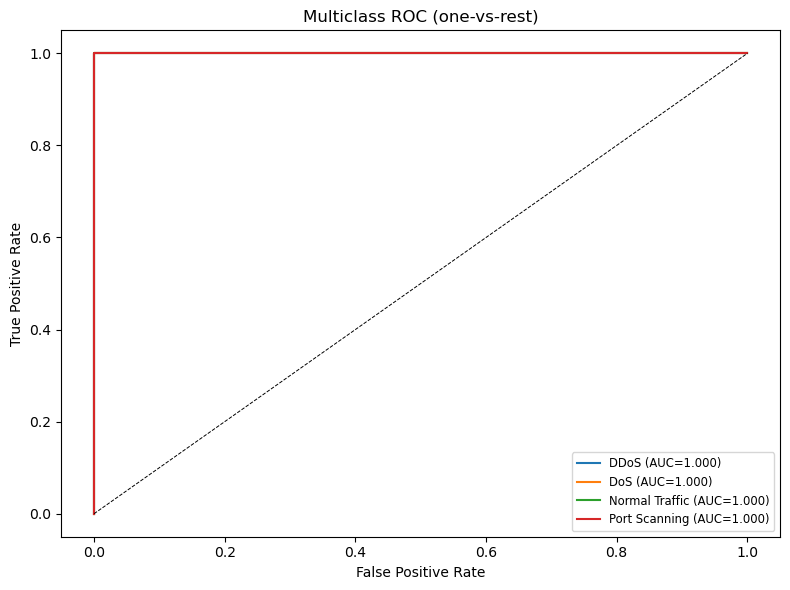

In [35]:
# CELL 9 — Evaluation metrics, classification report, confusion matrix, ROC (robust)

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# --- 1) Get predictions safely ---
preds = model.predict(X_test)

# Ensure lengths match
if len(preds) != len(y_test):
    raise ValueError(f"Prediction length {len(preds)} != y_test length {len(y_test)}")

# --- 2) Determine labels & target names consistently ---
# Use the set of labels that actually appear in y_test or preds
labels = np.unique(np.concatenate([np.asarray(y_test).reshape(-1,), np.asarray(preds).reshape(-1,)]))
labels = np.sort(labels)

# Build human-readable names for the labels (try label encoder 'le' if available)
try:
    if 'le' in globals() and hasattr(le, "classes_"):
        # If labels are integers that index into le.classes_, map them
        if np.issubdtype(labels.dtype, np.integer) and labels.max() < len(le.classes_):
            target_names = [le.classes_[int(l)] for l in labels]
        else:
            # Try to inverse transform string labels if le was used earlier
            try:
                tn = le.inverse_transform(labels)
                target_names = [str(x) for x in tn]
            except Exception:
                target_names = [str(l) for l in labels]
    else:
        target_names = [str(l) for l in labels]
except Exception:
    target_names = [str(l) for l in labels]

# --- 3) Print simple scalar metrics ---
acc = accuracy_score(y_test, preds)
rec = recall_score(y_test, preds, average='weighted', zero_division=0)
prec = precision_score(y_test, preds, average='weighted', zero_division=0)
f1 = f1_score(y_test, preds, average='weighted', zero_division=0)

print(f"Accuracy: {acc:.4f}  |  Recall (weighted): {rec:.4f}  |  Precision: {prec:.4f}  |  F1: {f1:.4f}\n")

# --- 4) Classification report (safe) ---
# Provide labels and matching target_names so sklearn won't complain about mismatch
print("Classification report:\n")
try:
    print(classification_report(y_test, preds, labels=labels.tolist(), target_names=target_names, zero_division=0))
except Exception as e:
    # Fallback: print default report without target names if sklearn still complains
    print("classification_report call failed, printing default report. (debug:", e, ")")
    print(classification_report(y_test, preds, zero_division=0))

# --- 5) Confusion matrix plot ---
cm = confusion_matrix(y_test, preds, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# --- 6) ROC curves (only if predict_proba available) ---
# Works for binary and multiclass (one-vs-rest)
if hasattr(model, "predict_proba"):
    try:
        probs = model.predict_proba(X_test)
        # If binary classifier, probs can be (n,2) -> use column 1
        n_classes = len(labels)
        if n_classes == 2:
            # binary ROC using positive class probability (assume second column)
            if probs.shape[1] == 2:
                fpr, tpr, _ = roc_curve(label_binarize(y_test, classes=labels).ravel(), probs[:, 1])
                roc_auc = auc(fpr, tpr)
                plt.figure(figsize=(6,4))
                plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
                plt.plot([0,1],[0,1],'k--', linewidth=0.7)
                plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
                plt.title('ROC curve (binary)')
                plt.legend(loc='lower right')
                plt.tight_layout()
                plt.show()
        else:
            # multiclass: one-vs-rest ROC
            y_test_bin = label_binarize(y_test, classes=labels)
            # Ensure probs shape matches classes; if not, try to adapt
            if probs.shape[1] != len(labels):
                # try to handle case where model outputs probs for only present classes
                # fallback, skip ROC if shapes mismatch
                print("Skipping multiclass ROC: predict_proba output shape doesn't match number of labels.")
            else:
                plt.figure(figsize=(8,6))
                for i, lab in enumerate(labels):
                    fpr, tpr, _ = roc_curve(y_test_bin[:, i], probs[:, i])
                    roc_auc = auc(fpr, tpr)
                    plt.plot(fpr, tpr, label=f"{target_names[i]} (AUC={roc_auc:.3f})")
                plt.plot([0,1],[0,1],'k--', linewidth=0.7)
                plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
                plt.title('Multiclass ROC (one-vs-rest)')
                plt.legend(loc='lower right', fontsize='small')
                plt.tight_layout()
                plt.show()
    except Exception as e_roc:
        print("ROC generation failed:", repr(e_roc))
else:
    print("Model does not implement predict_proba(); skipping ROC curves.")


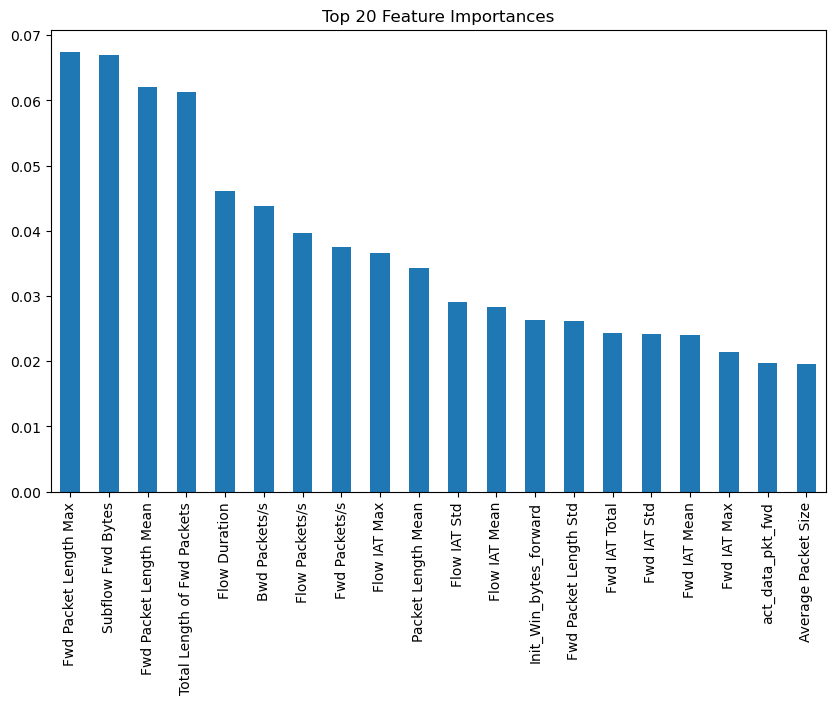

In [36]:
# Cell 10: feature importance plot
feat_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
feat_imp.head(20).plot(kind='bar')
plt.title('Top 20 Feature Importances')
plt.show()

In [37]:
# Cell 11: inference helpers and result card rendering
saved_cols = joblib.load(os.path.join(MODEL_DIR, 'columns.pkl')) if os.path.exists(os.path.join(MODEL_DIR, 'columns.pkl')) else X.columns.tolist()
label_enc = joblib.load(os.path.join(MODEL_DIR, 'label_encoder.pkl')) if os.path.exists(os.path.join(MODEL_DIR, 'label_encoder.pkl')) else le

def get_security_action(attack_type, confidence):
    at = str(attack_type).lower()
    if 'normal' in at or 'benign' in at:
        return 'Log & Allow', 'Traffic matches benign profile.'
    if 'dos' in at:
        return 'BLOCK SOURCE IP', f'DoS pattern detected ({confidence:.1%}).'
    if 'probe' in at or 'scan' in at or 'port' in at:
        return 'DROP PACKETS', 'Scanning activity detected.'
    if 'ransomware' in at or 'malware' in at:
        return 'ISOLATE HOST', 'Malicious payload signature match.'
    return ('FLAG FOR ANALYST' if confidence < 0.9 else 'BLOCK IP', 'Auto action based on confidence')

def infer_flow(model, flow_row):
    # flow_row: dict or pandas Series with raw features
    df_row = pd.DataFrame([flow_row])
    df_row = df_row.reindex(columns=saved_cols, fill_value=0)
    pred_idx = model.predict(df_row)[0]
    probs = model.predict_proba(df_row)[0]
    confidence = float(probs.max())
    attack_name = label_enc.inverse_transform([pred_idx])[0] if hasattr(label_enc, 'inverse_transform') else str(pred_idx)
    action, reason = get_security_action(attack_name, confidence)
    details = {'label': attack_name, 'confidence': confidence, 'action': action, 'reason': reason}
    return details, probs, df_row

from IPython.display import HTML as _HTML_display
def render_result_card(result):
    label = result['label']
    conf = result['confidence']
    action = result['action']
    reason = result['reason']
    color = '#2ecc71' if 'Allow' in action or 'LOG' in action else '#e74c3c' if 'BLOCK' in action or 'ISOLATE' in action else '#f1c40f'
    html = f"""
    <div style='border-radius:12px;padding:16px;background:#111827;color:#fff;max-width:720px'>
      <h2 style='margin:2px 0 6px 0'>Prediction: <span style='color:{color};'>{label}</span></h2>
      <p style='margin:2px 0'><strong>Confidence:</strong> {conf:.2%}</p>
      <p style='margin:2px 0'><strong>Suggested Action:</strong> <span style='font-weight:700'>{action}</span></p>
      <p style='margin:2px 0;color:#cbd5e1'><em>{reason}</em></p>
    </div>
    """
    display(_HTML_display(html))

def run_json_input(json_flow):
    if isinstance(json_flow, str):
        import json
        json_flow = json.loads(json_flow)
    result, probs, aligned = infer_flow(model, json_flow)
    clear_output(wait=True)
    render_result_card(result)
    plt.figure(figsize=(8,3))
    plt.bar(label_enc.inverse_transform(range(len(probs))), probs)
    plt.xticks(rotation=45, ha='right')
    plt.title('Prediction probabilities')
    plt.show()
    sample = aligned.iloc[0]
    dif = (sample - X.median()).abs().sort_values(ascending=False)
    top = dif.head(8)
    plt.figure(figsize=(8,3))
    sns.barplot(x=top.values, y=top.index)
    plt.title('Top 8 feature deviations from median (proxy for contribution)')
    plt.show()


In [39]:
# Cell 12: interactive widget demo (requires ipywidgets)
def interactive_flow_demo():
    if not WIDGETS_AVAILABLE:
        print('ipywidgets not available in this environment. Use run_json_input(...) instead.')
        return
    top_feats = feat_imp.head(8).index.tolist()
    controls = {}
    for f in top_feats:
        controls[f] = widgets.FloatText(value=float(X[f].median()), description=f, layout=widgets.Layout(width='60%'))
    run_button = widgets.Button(description='Classify flow', button_style='primary')
    out = widgets.Output()

    def on_click(b):
        with out:
            clear_output()
            flow = {f: controls[f].value for f in top_feats}
            # fill the rest with medians
            for c in saved_cols:
                if c not in flow:
                    flow[c] = float(X[c].median()) if c in X.columns else 0
            result, probs, aligned = infer_flow(model, flow)
            render_result_card(result)
            plt.figure(figsize=(8,3))
            plt.bar(label_enc.inverse_transform(range(len(probs))), probs)
            plt.xticks(rotation=45, ha='right')
            plt.title('Prediction probabilities')
            plt.show()
            sample = aligned.iloc[0]
            dif = (sample - X.median()).abs().sort_values(ascending=False)
            top = dif.head(8)
            plt.figure(figsize=(8,3))
            sns.barplot(x=top.values, y=top.index)
            plt.title('Top 8 feature deviations from median (proxy for contribution)')
            plt.show()

    run_button.on_click(on_click)
    controls_box = widgets.VBox([controls[f] for f in top_feats] + [run_button])
    display(widgets.HBox([controls_box, out]))



--- Demo sample index: 484 ---


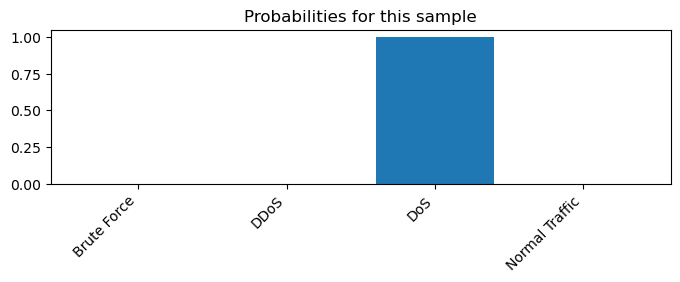


--- Demo sample index: 264 ---


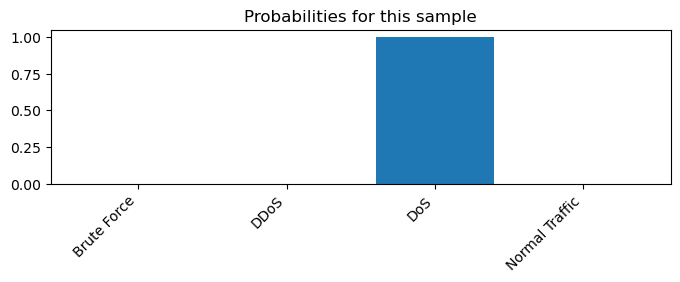


--- Demo sample index: 338 ---


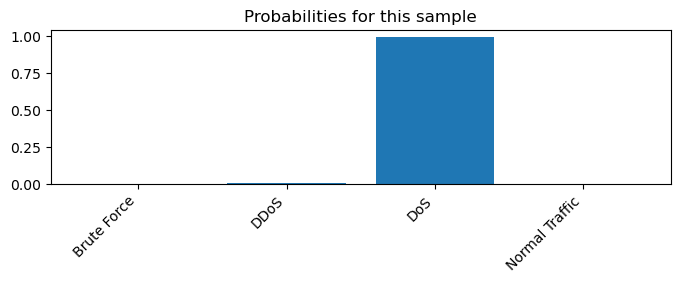


--- Demo sample index: 122 ---


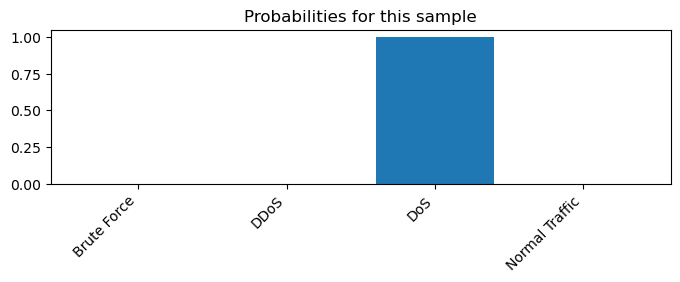


--- Demo sample index: 78 ---


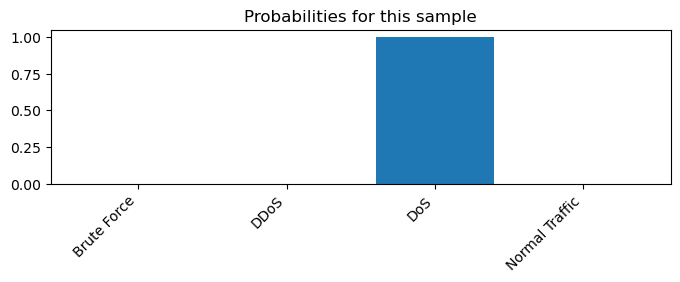


--- Demo sample index: 325 ---


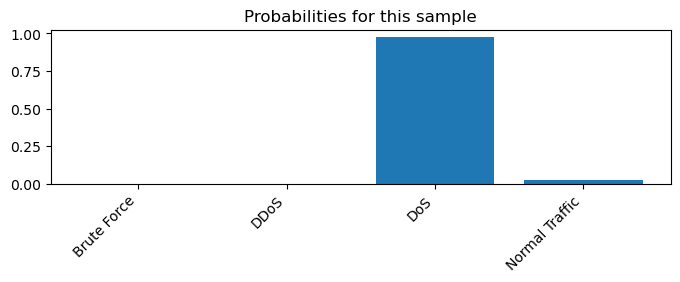

Saved visual report to models\quick_report.png

Notebook cells complete. Use `interactive_flow_demo()` or `run_json_input(...)` to test flows.


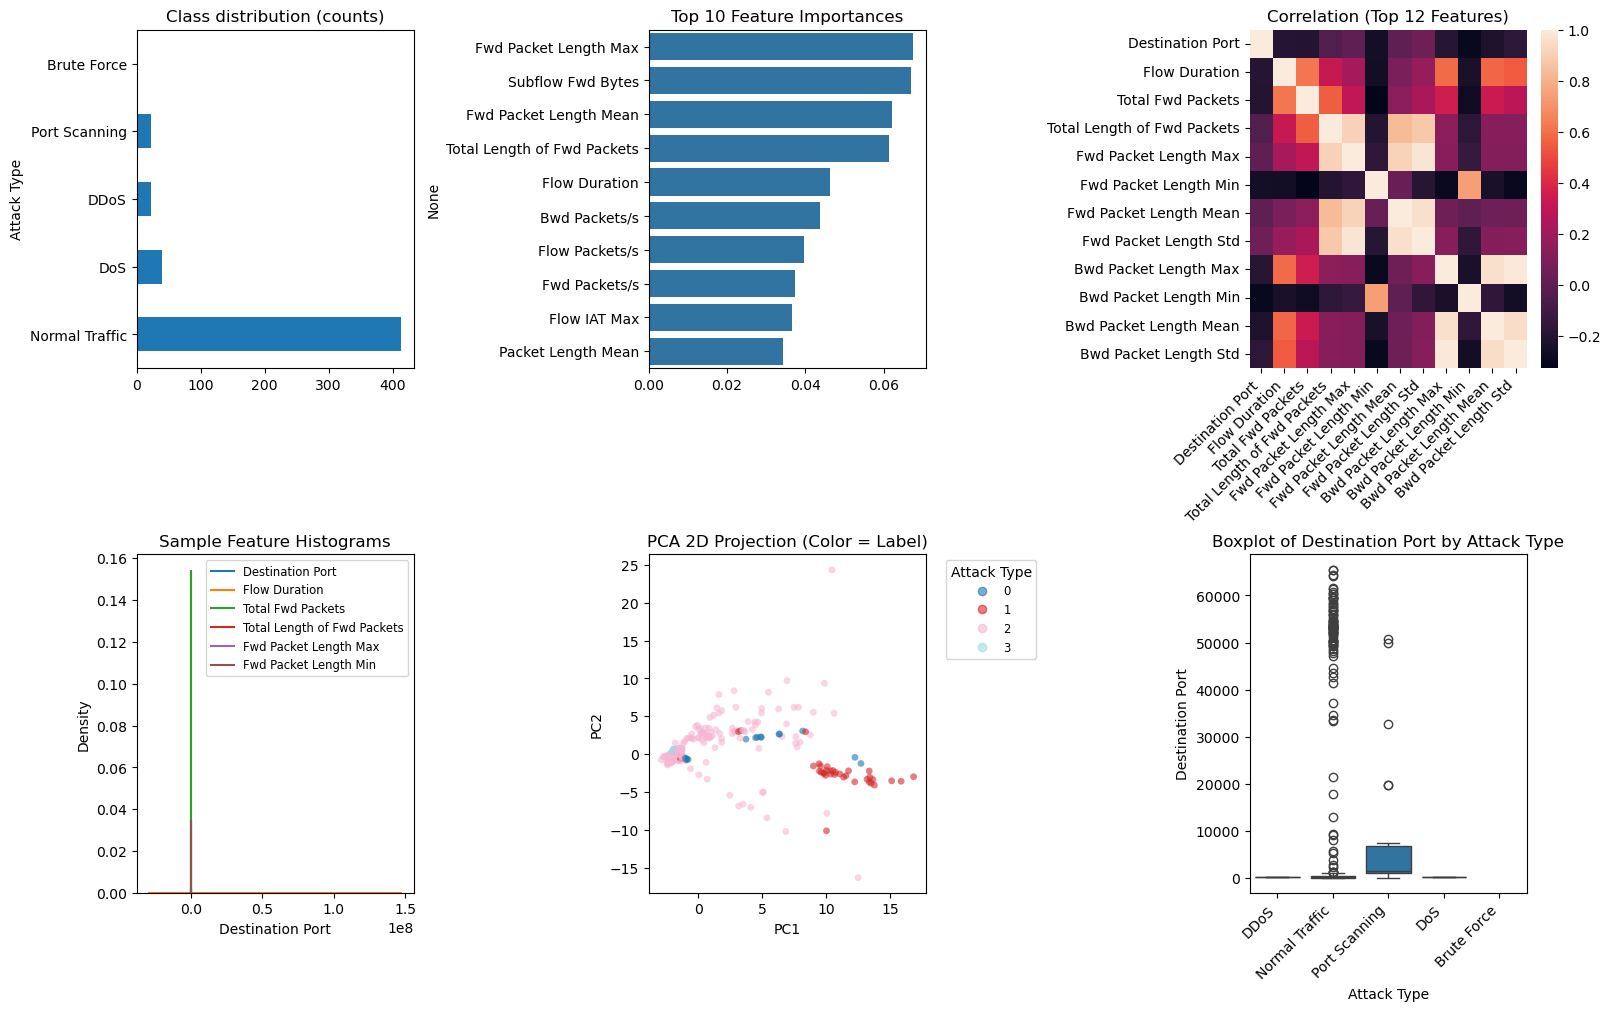

In [40]:
# Cell 13: demo loop on test samples and save a quick visual report
sample_demo = X_test.copy()
sample_demo['Attack Type'] = label_enc.inverse_transform(y_test)
sample_demo = sample_demo.sample(min(6, len(sample_demo)))

for idx, row in sample_demo.iterrows():
    flow = row.to_dict()
    flow.pop('Attack Type', None)
    print('\n--- Demo sample index:', idx, '---')
    result, probs, aligned = infer_flow(model, flow)
    render_result_card(result)
    plt.figure(figsize=(8,2))
    plt.bar(label_enc.inverse_transform(range(len(probs))), probs)
    plt.title('Probabilities for this sample')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Save a quick visual report PNG
report_png = os.path.join(MODEL_DIR, 'quick_report.png')
fig = eda_dashboard(model=model, show=False)
fig.savefig(report_png, dpi=150, bbox_inches='tight')
print('Saved visual report to', report_png)
joblib.dump({'model_file': model_file, 'report_png': report_png}, os.path.join(MODEL_DIR, 'meta.pkl'))

print("\nNotebook cells complete. Use `interactive_flow_demo()` or `run_json_input(...)` to test flows.")


In [52]:
interactive_flow_demo()